In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-03-14 10:30:43.393892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-14 10:30:43.393956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-14 10:30:43.393964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

### Load and process data

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [ ]:
data = pd.read_pickle('../data/data_proton_photonsum_70_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_70_2312_0_3360.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

In [ ]:
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()
photon_sum_neutron_min, photon_sum_neutron_max = data_cond.neutron_photon_sum.min(), data_cond.neutron_photon_sum.max()

In [ ]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)
data_cond.columns, len(data_cond.columns)

In [ ]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "gan"

EXPERIMENT_DIR_NAME = f"{NAME}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

In [ ]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [ ]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [ ]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

In [ ]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_cond)).shuffle(12800)

### Define Model

In [ ]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [ ]:
latent_dim = 10
cond_dim = 10
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(128*8*4)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((8,4,128))(layer_2_a)
reshaped_s = UpSampling2D(size=(2,2))(reshaped)

conv1 = Conv2D(128, kernel_size=3, padding='same')(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D(size=(4,4))(conv1_a)

conv2 = Conv2D(64, kernel_size=(7, 1))(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

outputs = Conv2D(1, kernel_size=3, activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,30,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

In [ ]:
# latent_dim = 10
# cond_dim = 10
# poz_dim = 6

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*28*15)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((28, 15, 128))(layer_2_a)
# # reshaped_s = UpSampling2D()(reshaped)

# conv1 = Conv2D(128, kernel_size=1)(reshaped)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D()(conv1_a)

# conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56,30,1],name='input_img')
# conv1 = Conv2D(32, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
# conv2 = Conv2D(16, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
# outputs = Dense(1, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], outputs, name='discriminator')
# discriminator.summary()

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [ ]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [ ]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)
    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [ ]:
@tf.function
def train_step(batch,step):
    images, cond, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,noise_cond], training=True)

        real_output = discriminator([images,cond], training=True)
        fake_output = discriminator([generated_images, noise_cond], training=True)

        gen_loss = generator_loss(step, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
filepath_mod = f"../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    
    # genrate first image
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            gen_loss, disc_loss =train_step(batch,tf_step)
            history.append([gen_loss,disc_loss,
                100*d_acc_r.result().numpy(),
                100*d_acc_f.result().numpy(),
                100*g_acc.result().numpy(),
                ])
            tf_step.assign_add(1)
            step = step+1

            if step % 100 == 0:
                print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
                    step,
                    100*d_acc_r.result().numpy(),
                    100*d_acc_f.result().numpy(),
                    100*g_acc.result().numpy()))

        generate_and_save_images(generator,
                                 epoch,
                                 [seed, seed_cond])

        # Save the model every epoch
        generator.save_weights((os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5")))
        discriminator.save_weights((os.path.join(filepath_mod, "disc_"+NAME + "_"+ str(epoch) +".h5")))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),np.array(history))

        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # generate last image
    generate_and_save_images(generator,
                             epochs + 1,
                             [seed, seed_cond]
                            )

    return history

In [ ]:
filepath_img = f"../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

def generate_and_save_images(model, epoch, test_input):
    
    SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

In [ ]:
print("Images are saved in: ", filepath_img)
print("Models are saved in: ", filepath_mod)
history=train(dataset_with_cond, EPOCHS)

Images are saved in:  ../images/gan_14_03_2023_10_30/
Models are saved in:  ../models/gan_14_03_2023_10_30/


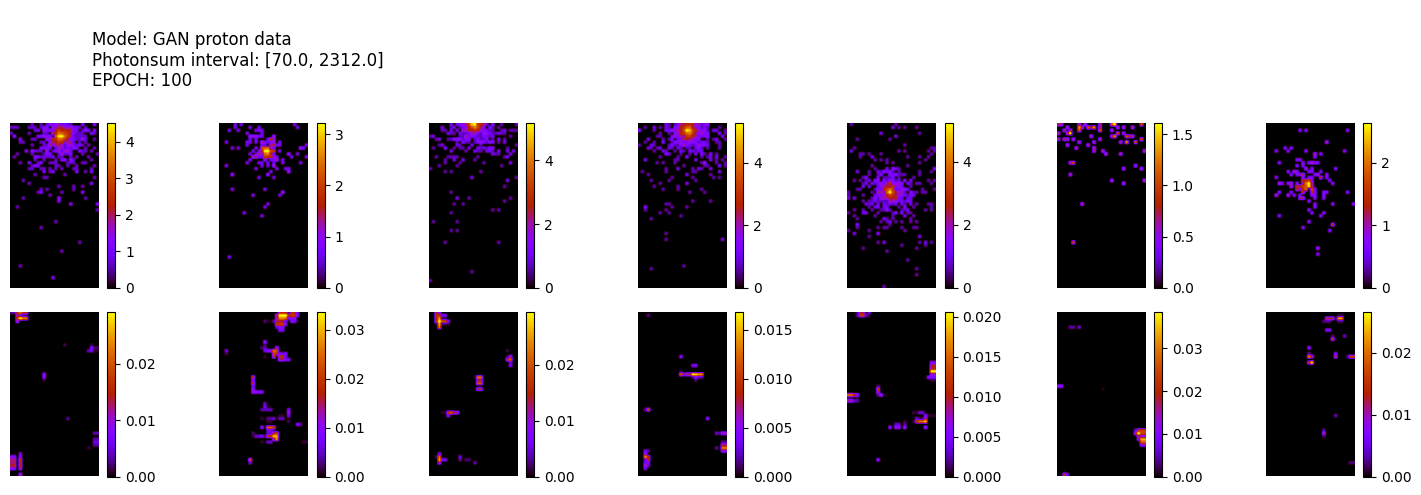

100 [D real acc: 58.98%] [D fake acc: 44.84%] [G acc: 55.16%] 
200 [D real acc: 61.27%] [D fake acc: 47.26%] [G acc: 52.74%] 
256/256 [==============================] - 1s 3ms/step
ws mean 118.36 ch1 0.20 ch2 103.92 ch3 0.70 ch4 191.24 ch5 295.74 Time for epoch 1 is 32.89678430557251 sec
300 [D real acc: 63.32%] [D fake acc: 49.02%] [G acc: 50.98%] 
400 [D real acc: 64.70%] [D fake acc: 50.84%] [G acc: 49.16%] 
500 [D real acc: 65.46%] [D fake acc: 52.06%] [G acc: 47.94%] 
256/256 [==============================] - 1s 3ms/step
ws mean 85.89 ch1 0.12 ch2 68.92 ch3 0.55 ch4 145.45 ch5 214.41 Time for epoch 2 is 21.53474235534668 sec
600 [D real acc: 66.27%] [D fake acc: 53.48%] [G acc: 46.52%] 


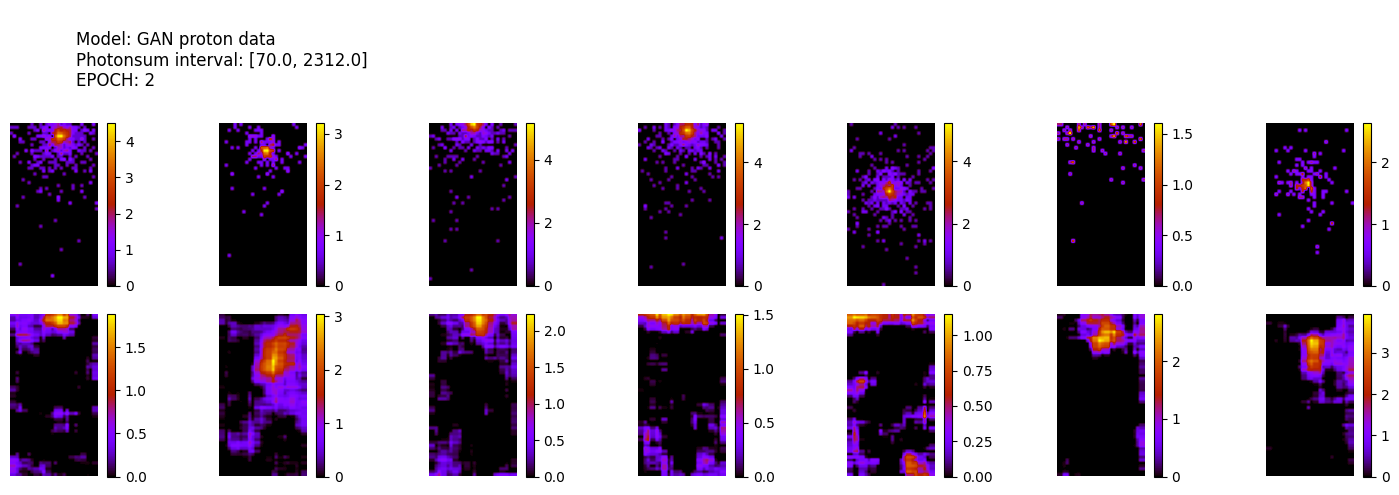

700 [D real acc: 66.87%] [D fake acc: 54.87%] [G acc: 45.13%] 
256/256 [==============================] - 1s 3ms/step
ws mean 69.19 ch1 0.11 ch2 58.41 ch3 0.42 ch4 114.40 ch5 172.62 Time for epoch 3 is 23.482360363006592 sec
800 [D real acc: 67.34%] [D fake acc: 55.94%] [G acc: 44.06%] 
900 [D real acc: 67.55%] [D fake acc: 57.10%] [G acc: 42.90%] 
1000 [D real acc: 67.97%] [D fake acc: 58.15%] [G acc: 41.85%] 
256/256 [==============================] - 1s 3ms/step
ws mean 64.49 ch1 0.11 ch2 52.25 ch3 0.46 ch4 109.95 ch5 159.68 Time for epoch 4 is 21.659319162368774 sec
1100 [D real acc: 68.33%] [D fake acc: 59.12%] [G acc: 40.88%] 
1200 [D real acc: 68.57%] [D fake acc: 60.03%] [G acc: 39.97%] 


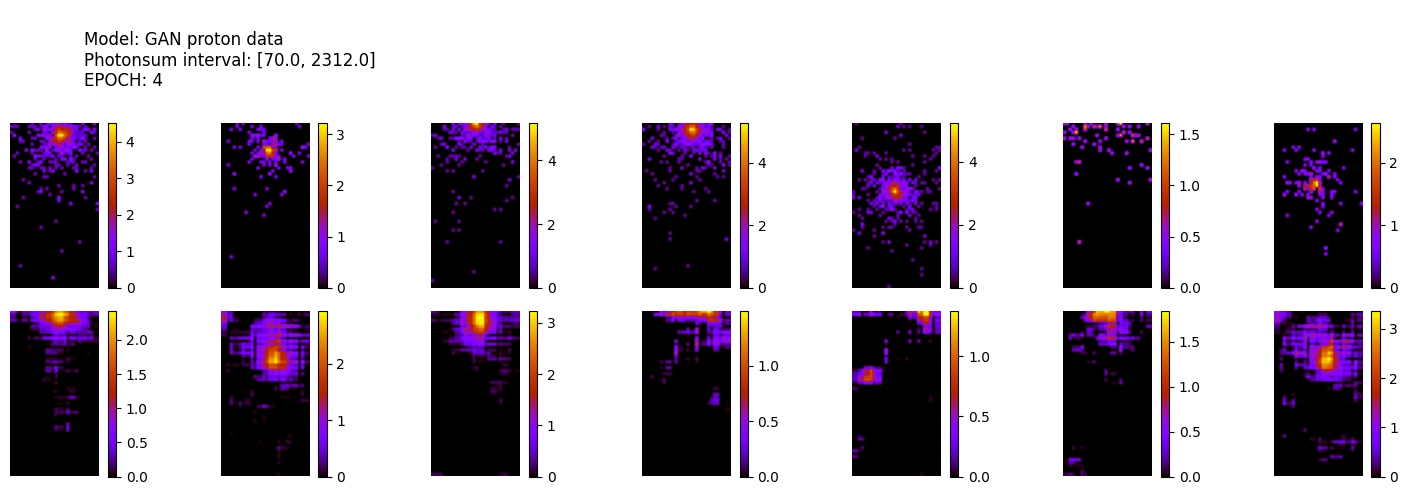

256/256 [==============================] - 1s 3ms/step
ws mean 38.65 ch1 0.13 ch2 42.97 ch3 0.23 ch4 52.37 ch5 97.54 Time for epoch 5 is 23.323941707611084 sec
1300 [D real acc: 68.88%] [D fake acc: 60.82%] [G acc: 39.18%] 
1400 [D real acc: 69.25%] [D fake acc: 61.55%] [G acc: 38.45%] 
1500 [D real acc: 69.59%] [D fake acc: 62.15%] [G acc: 37.85%] 
256/256 [==============================] - 1s 3ms/step
ws mean 52.23 ch1 0.10 ch2 66.81 ch3 0.35 ch4 68.12 ch5 125.76 Time for epoch 6 is 23.762510776519775 sec
1600 [D real acc: 69.86%] [D fake acc: 62.75%] [G acc: 37.25%] 
1700 [D real acc: 70.05%] [D fake acc: 63.36%] [G acc: 36.64%] 
256/256 [==============================] - 1s 3ms/step
ws mean 46.24 ch1 0.12 ch2 71.91 ch3 0.23 ch4 47.47 ch5 111.47 Time for epoch 7 is 23.755475759506226 sec
1800 [D real acc: 70.30%] [D fake acc: 63.84%] [G acc: 36.16%] 


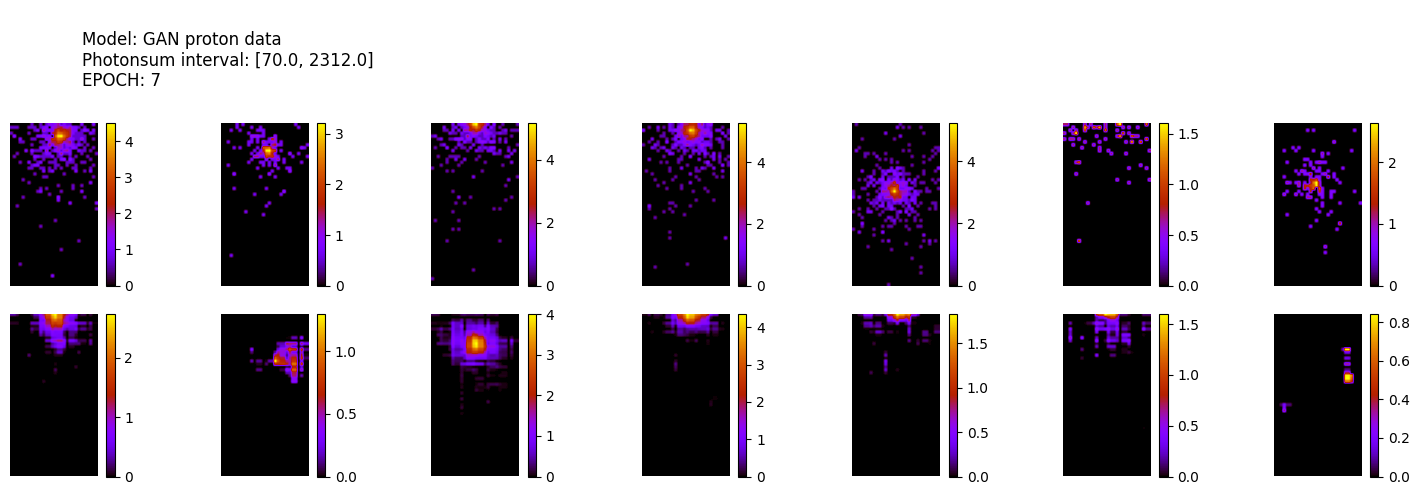

1900 [D real acc: 70.53%] [D fake acc: 64.30%] [G acc: 35.70%] 
2000 [D real acc: 70.78%] [D fake acc: 64.74%] [G acc: 35.26%] 
256/256 [==============================] - 1s 3ms/step
ws mean 42.54 ch1 0.10 ch2 41.84 ch3 0.37 ch4 68.12 ch5 102.25 Time for epoch 8 is 25.598943948745728 sec
2100 [D real acc: 70.97%] [D fake acc: 65.23%] [G acc: 34.77%] 
2200 [D real acc: 71.21%] [D fake acc: 65.69%] [G acc: 34.31%] 
2300 [D real acc: 71.44%] [D fake acc: 66.18%] [G acc: 33.82%] 
256/256 [==============================] - 1s 3ms/step
ws mean 47.29 ch1 0.21 ch2 34.31 ch3 0.42 ch4 90.88 ch5 110.60 Time for epoch 9 is 23.781652212142944 sec
2400 [D real acc: 71.73%] [D fake acc: 66.61%] [G acc: 33.39%] 


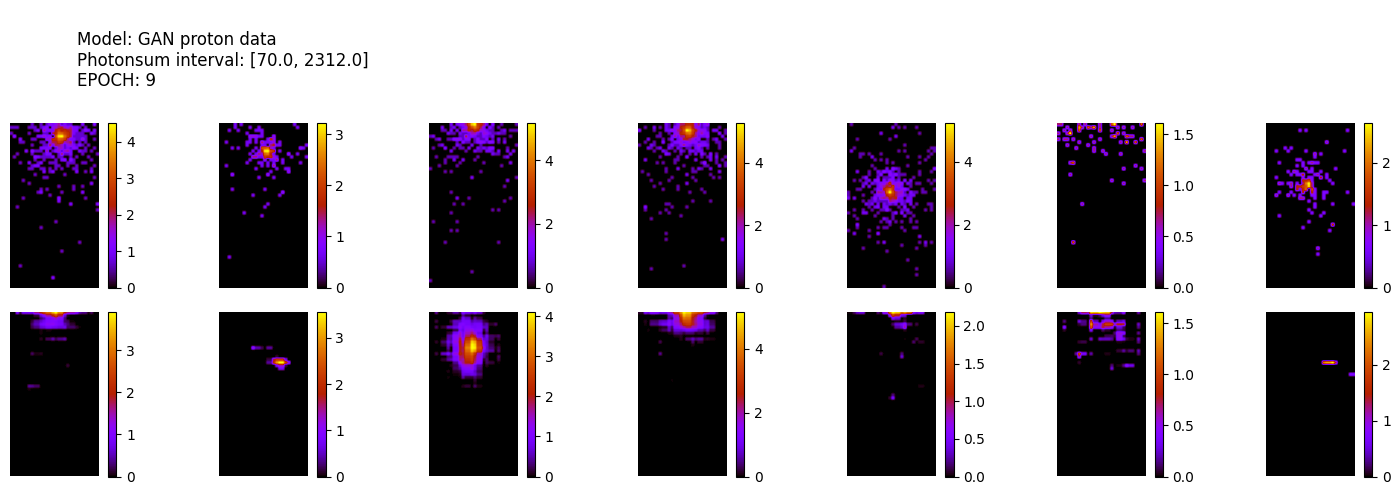

2500 [D real acc: 72.02%] [D fake acc: 67.09%] [G acc: 32.91%] 
256/256 [==============================] - 1s 3ms/step
ws mean 57.47 ch1 0.11 ch2 54.13 ch3 0.33 ch4 89.26 ch5 143.52 Time for epoch 10 is 25.38490891456604 sec
2600 [D real acc: 72.33%] [D fake acc: 67.57%] [G acc: 32.43%] 
2700 [D real acc: 72.65%] [D fake acc: 68.04%] [G acc: 31.96%] 
2800 [D real acc: 73.00%] [D fake acc: 68.52%] [G acc: 31.48%] 
256/256 [==============================] - 1s 3ms/step
ws mean 35.38 ch1 0.15 ch2 24.90 ch3 0.45 ch4 75.24 ch5 76.17 Time for epoch 11 is 25.83855414390564 sec
2900 [D real acc: 73.34%] [D fake acc: 69.05%] [G acc: 30.95%] 
3000 [D real acc: 73.71%] [D fake acc: 69.58%] [G acc: 30.42%] 


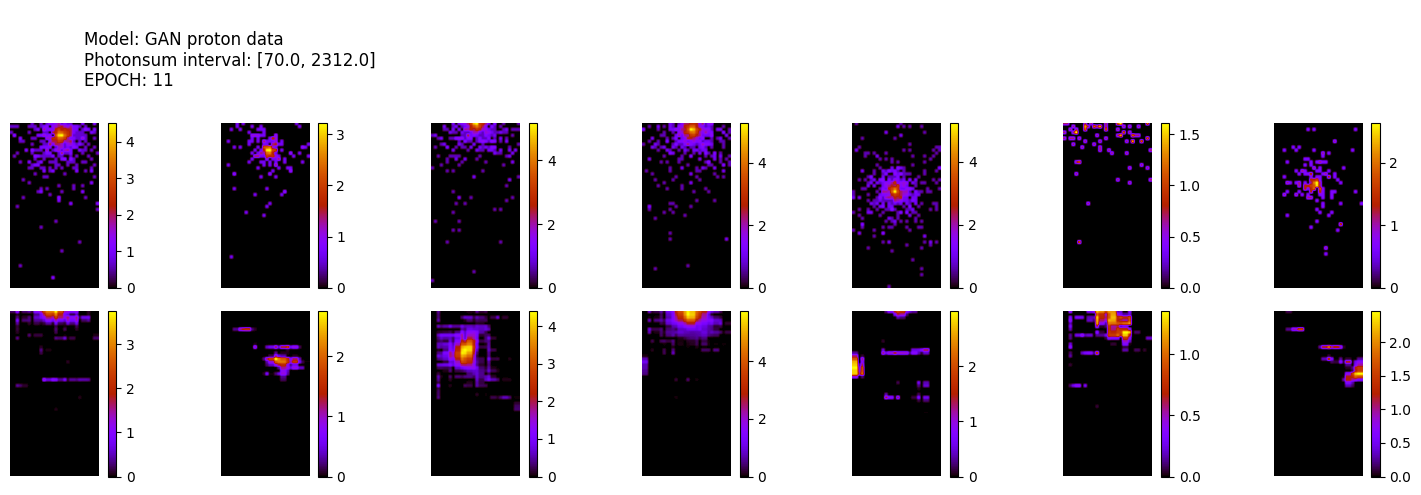

256/256 [==============================] - 1s 3ms/step
ws mean 76.06 ch1 0.13 ch2 17.81 ch3 0.61 ch4 181.29 ch5 180.44 Time for epoch 12 is 27.522742748260498 sec
3100 [D real acc: 74.09%] [D fake acc: 70.05%] [G acc: 29.95%] 
3200 [D real acc: 74.49%] [D fake acc: 70.55%] [G acc: 29.45%] 
3300 [D real acc: 74.91%] [D fake acc: 71.02%] [G acc: 28.98%] 
256/256 [==============================] - 1s 3ms/step
ws mean 175.48 ch1 0.41 ch2 115.52 ch3 1.48 ch4 332.88 ch5 427.10 Time for epoch 13 is 25.826806783676147 sec
3400 [D real acc: 75.32%] [D fake acc: 71.56%] [G acc: 28.44%] 
3500 [D real acc: 75.73%] [D fake acc: 72.06%] [G acc: 27.94%] 
256/256 [==============================] - 1s 3ms/step
ws mean 62.85 ch1 0.11 ch2 38.99 ch3 0.50 ch4 118.68 ch5 155.94 Time for epoch 14 is 25.79085111618042 sec
3600 [D real acc: 76.17%] [D fake acc: 72.51%] [G acc: 27.49%] 


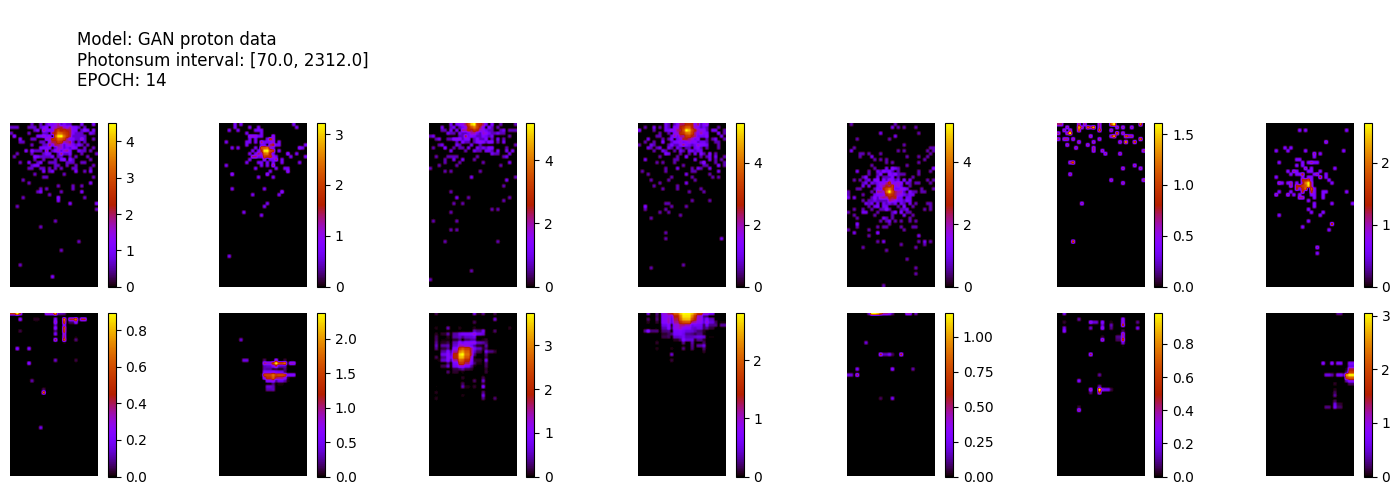

3700 [D real acc: 76.60%] [D fake acc: 73.06%] [G acc: 26.94%] 
3800 [D real acc: 77.01%] [D fake acc: 73.47%] [G acc: 26.53%] 
256/256 [==============================] - 1s 3ms/step
ws mean 43.68 ch1 0.11 ch2 47.20 ch3 0.29 ch4 62.62 ch5 108.19 Time for epoch 15 is 27.468251705169678 sec
3900 [D real acc: 77.40%] [D fake acc: 73.89%] [G acc: 26.11%] 
4000 [D real acc: 77.79%] [D fake acc: 74.33%] [G acc: 25.67%] 
256/256 [==============================] - 1s 3ms/step
ws mean 152.67 ch1 0.39 ch2 62.99 ch3 1.28 ch4 317.46 ch5 381.22 Time for epoch 16 is 27.77699875831604 sec
4100 [D real acc: 78.16%] [D fake acc: 74.71%] [G acc: 25.29%] 
4200 [D real acc: 78.56%] [D fake acc: 75.00%] [G acc: 25.00%] 


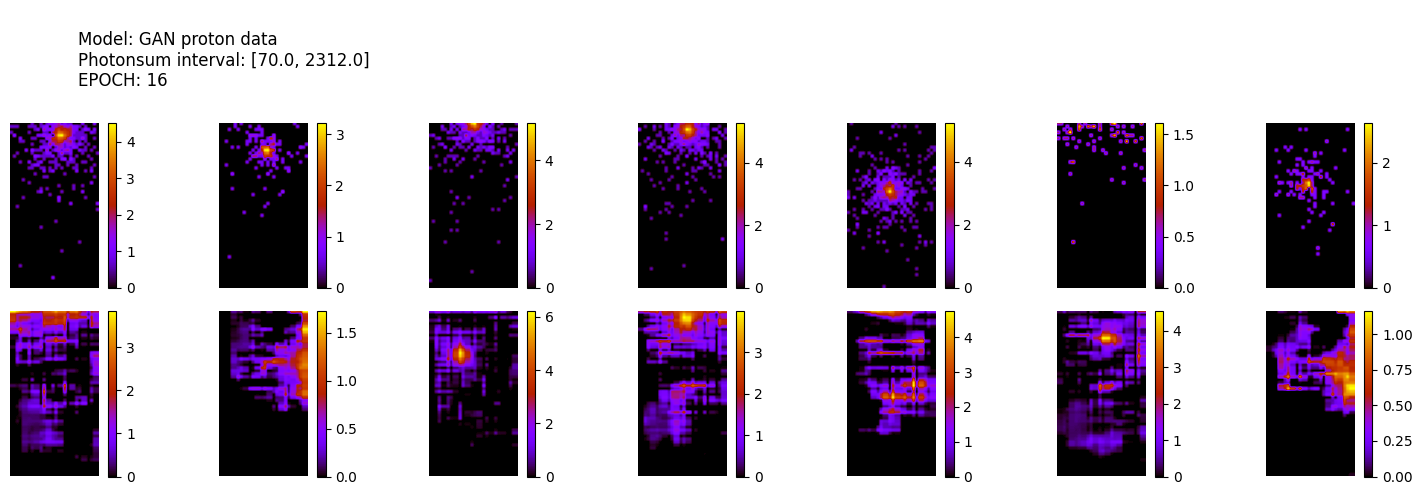

4300 [D real acc: 78.91%] [D fake acc: 75.27%] [G acc: 24.73%] 
256/256 [==============================] - 1s 3ms/step
ws mean 10693.82 ch1 27.39 ch2 13521.61 ch3 28.87 ch4 13168.74 ch5 26722.49 Time for epoch 17 is 29.614896774291992 sec
4400 [D real acc: 79.21%] [D fake acc: 75.52%] [G acc: 24.48%] 
4500 [D real acc: 79.49%] [D fake acc: 75.88%] [G acc: 24.12%] 
4600 [D real acc: 79.82%] [D fake acc: 76.28%] [G acc: 23.72%] 
256/256 [==============================] - 1s 3ms/step
ws mean 822.15 ch1 2.64 ch2 797.34 ch3 2.19 ch4 1254.48 ch5 2054.12 Time for epoch 18 is 27.847504138946533 sec
4700 [D real acc: 80.16%] [D fake acc: 76.59%] [G acc: 23.41%] 
4800 [D real acc: 80.51%] [D fake acc: 76.91%] [G acc: 23.09%] 


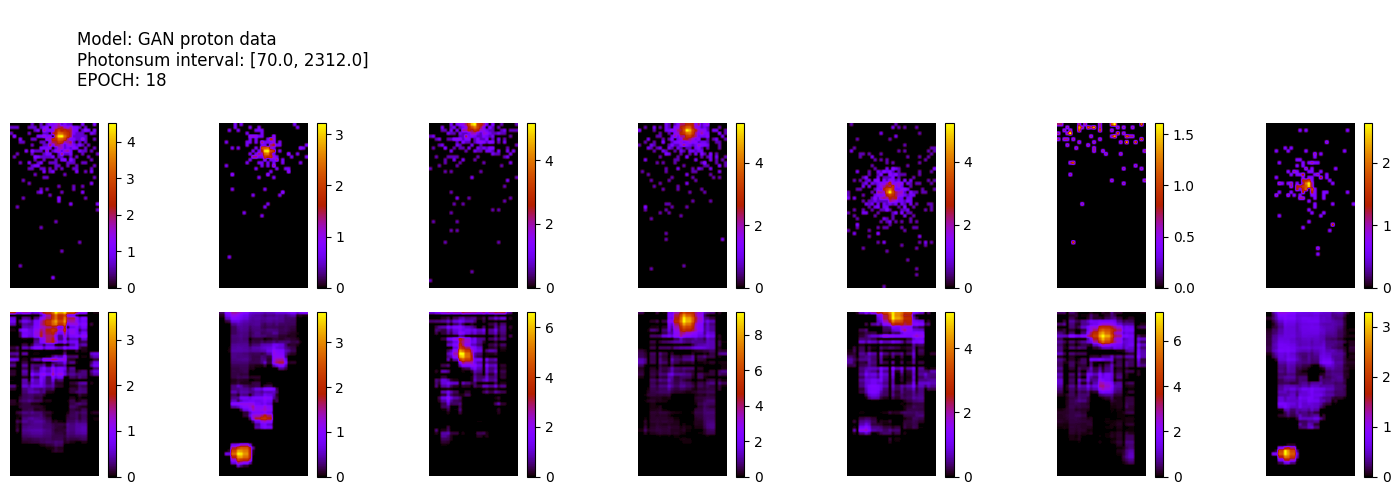

256/256 [==============================] - 1s 3ms/step
ws mean 2829.85 ch1 1.25 ch2 363.80 ch3 17.90 ch4 6673.05 ch5 7093.27 Time for epoch 19 is 29.350823640823364 sec
4900 [D real acc: 80.85%] [D fake acc: 77.22%] [G acc: 22.78%] 
5000 [D real acc: 81.19%] [D fake acc: 77.53%] [G acc: 22.47%] 
5100 [D real acc: 81.50%] [D fake acc: 77.85%] [G acc: 22.15%] 
256/256 [==============================] - 1s 3ms/step
ws mean 218.93 ch1 0.51 ch2 126.02 ch3 1.31 ch4 421.06 ch5 545.77 Time for epoch 20 is 28.007385969161987 sec
5200 [D real acc: 81.80%] [D fake acc: 78.19%] [G acc: 21.81%] 
5300 [D real acc: 82.09%] [D fake acc: 78.56%] [G acc: 21.44%] 
256/256 [==============================] - 1s 3ms/step
ws mean 162.90 ch1 0.22 ch2 204.02 ch3 0.78 ch4 206.41 ch5 403.08 Time for epoch 21 is 29.83037519454956 sec
5400 [D real acc: 82.39%] [D fake acc: 78.94%] [G acc: 21.06%] 


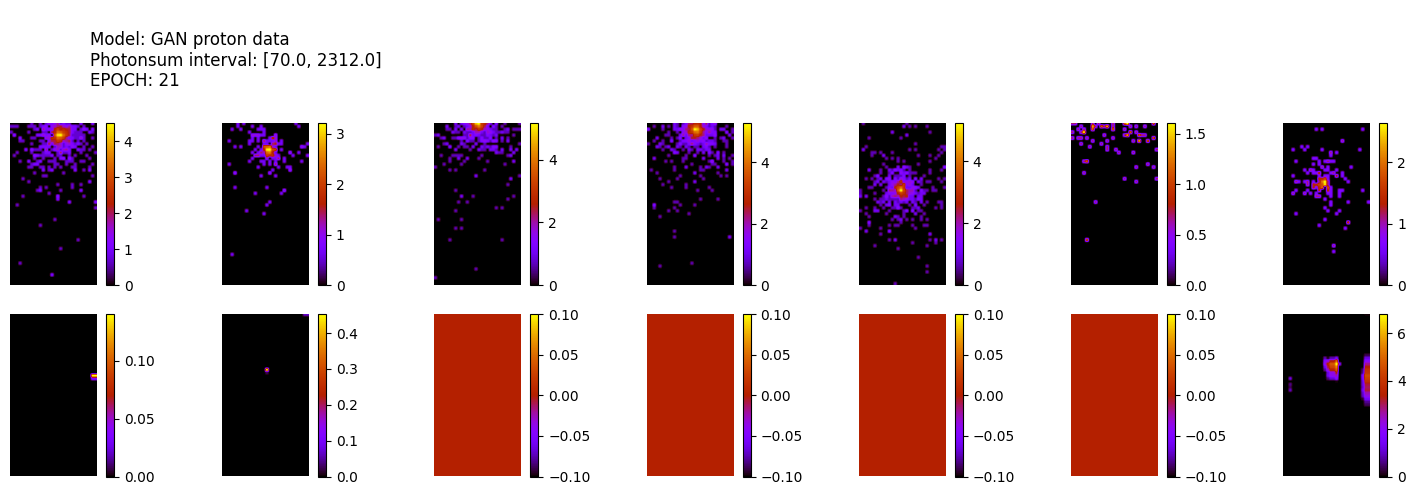

5500 [D real acc: 82.68%] [D fake acc: 79.31%] [G acc: 20.69%] 
5600 [D real acc: 82.97%] [D fake acc: 79.64%] [G acc: 20.36%] 
256/256 [==============================] - 1s 3ms/step
ws mean 128.56 ch1 0.20 ch2 111.95 ch3 0.79 ch4 208.67 ch5 321.17 Time for epoch 22 is 31.233386039733887 sec
5700 [D real acc: 83.24%] [D fake acc: 79.96%] [G acc: 20.04%] 
5800 [D real acc: 83.51%] [D fake acc: 80.23%] [G acc: 19.77%] 
256/256 [==============================] - 1s 3ms/step
ws mean 90.34 ch1 0.25 ch2 72.85 ch3 0.68 ch4 178.71 ch5 199.20 Time for epoch 23 is 29.942723274230957 sec
5900 [D real acc: 83.75%] [D fake acc: 80.48%] [G acc: 19.52%] 
6000 [D real acc: 83.98%] [D fake acc: 80.74%] [G acc: 19.26%] 


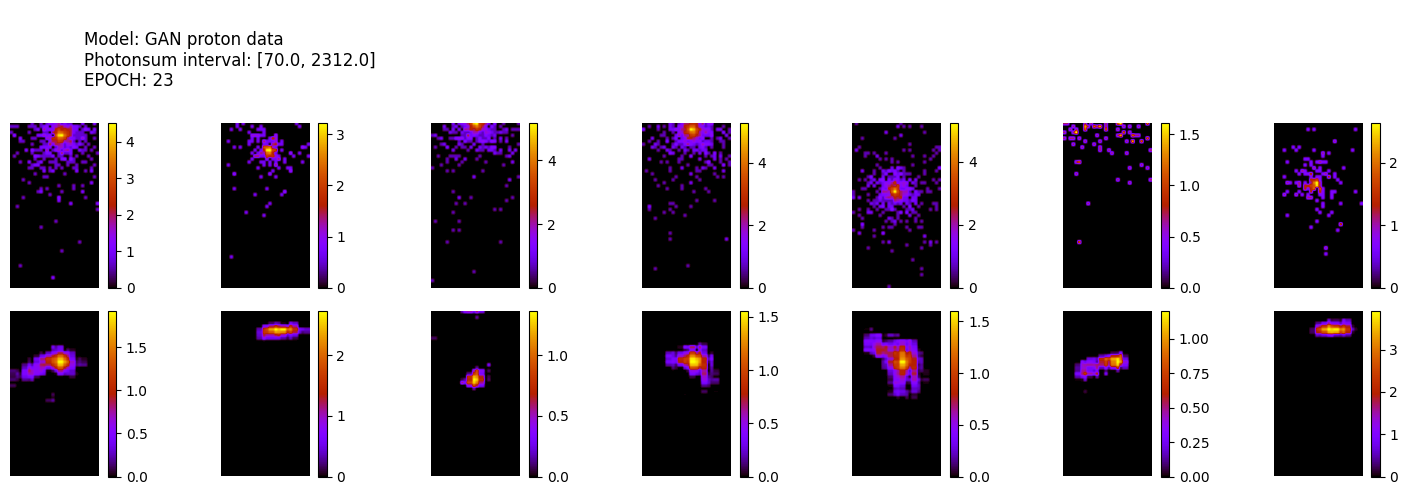

6100 [D real acc: 84.21%] [D fake acc: 80.98%] [G acc: 19.02%] 
256/256 [==============================] - 1s 3ms/step
ws mean 98.12 ch1 0.11 ch2 75.41 ch3 0.66 ch4 169.33 ch5 245.09 Time for epoch 24 is 31.437616109848022 sec
6200 [D real acc: 84.43%] [D fake acc: 81.22%] [G acc: 18.78%] 
6300 [D real acc: 84.63%] [D fake acc: 81.46%] [G acc: 18.54%] 
6400 [D real acc: 84.83%] [D fake acc: 81.70%] [G acc: 18.30%] 
256/256 [==============================] - 1s 3ms/step
ws mean 959.23 ch1 0.14 ch2 67.44 ch3 2.62 ch4 2339.34 ch5 2386.59 Time for epoch 25 is 30.238059520721436 sec
6500 [D real acc: 85.02%] [D fake acc: 81.93%] [G acc: 18.07%] 
6600 [D real acc: 85.20%] [D fake acc: 82.16%] [G acc: 17.84%] 


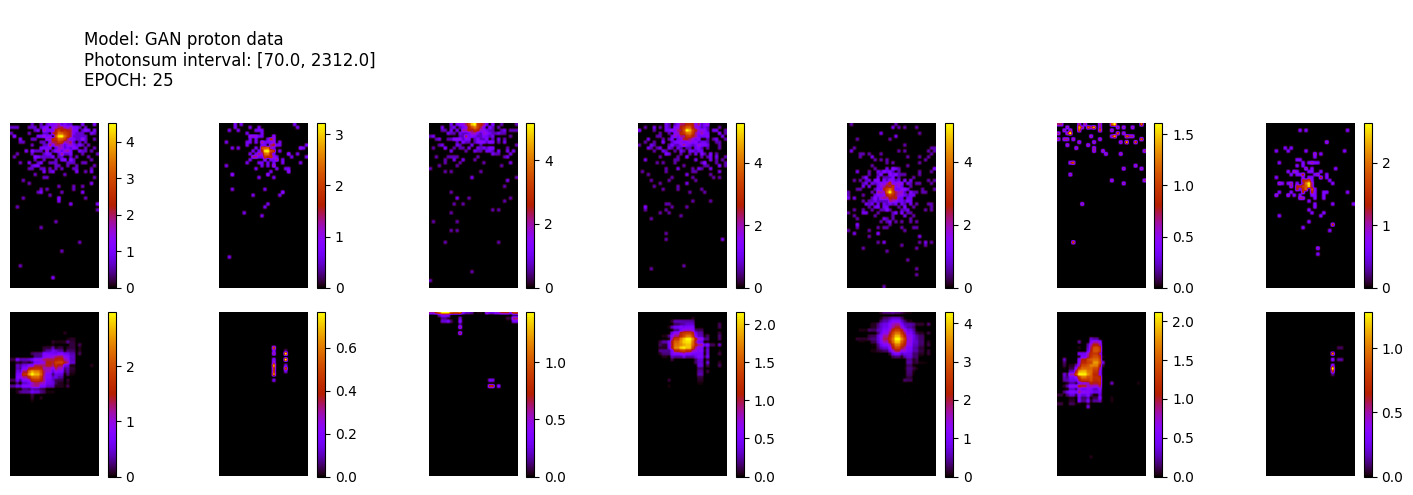

256/256 [==============================] - 1s 3ms/step
ws mean 73.93 ch1 0.19 ch2 40.17 ch3 0.55 ch4 151.13 ch5 177.59 Time for epoch 26 is 31.79248023033142 sec
6700 [D real acc: 85.39%] [D fake acc: 82.36%] [G acc: 17.64%] 
6800 [D real acc: 85.59%] [D fake acc: 82.56%] [G acc: 17.44%] 
6900 [D real acc: 85.76%] [D fake acc: 82.78%] [G acc: 17.22%] 
256/256 [==============================] - 1s 3ms/step
ws mean 165.78 ch1 0.12 ch2 79.43 ch3 0.70 ch4 345.12 ch5 403.53 Time for epoch 27 is 29.97585415840149 sec
7000 [D real acc: 85.94%] [D fake acc: 82.99%] [G acc: 17.01%] 
7100 [D real acc: 86.10%] [D fake acc: 83.19%] [G acc: 16.81%] 
256/256 [==============================] - 1s 3ms/step
ws mean 63.28 ch1 0.26 ch2 29.05 ch3 0.57 ch4 131.48 ch5 155.01 Time for epoch 28 is 30.275445222854614 sec
7200 [D real acc: 86.28%] [D fake acc: 83.40%] [G acc: 16.60%] 


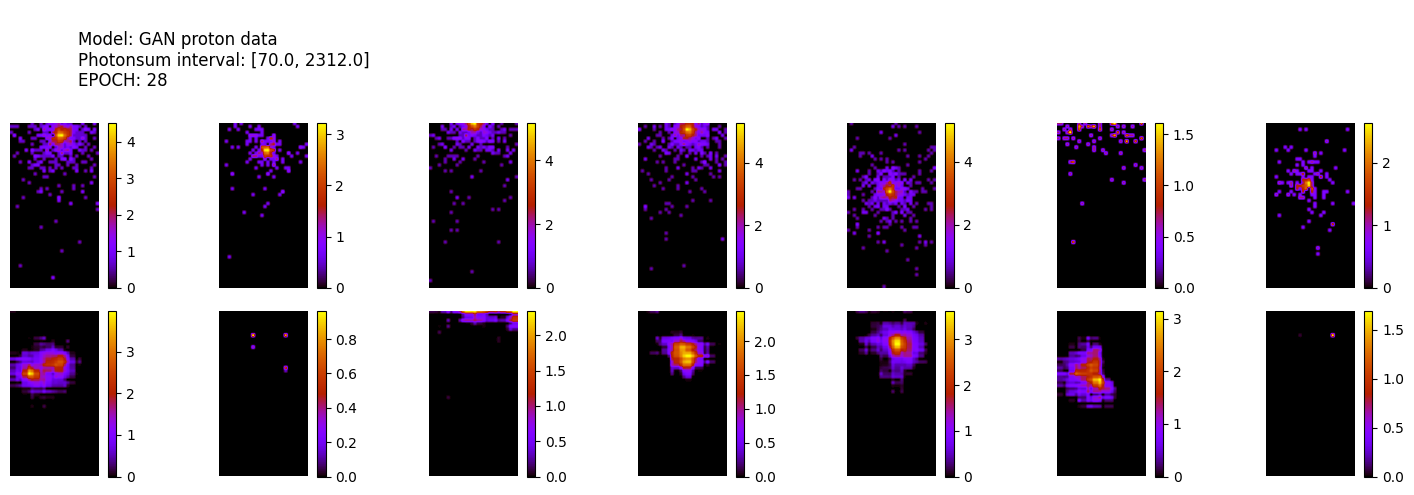

7300 [D real acc: 86.44%] [D fake acc: 83.60%] [G acc: 16.40%] 
7400 [D real acc: 86.61%] [D fake acc: 83.78%] [G acc: 16.22%] 
256/256 [==============================] - 1s 3ms/step
ws mean 57.05 ch1 0.17 ch2 39.77 ch3 0.45 ch4 105.04 ch5 139.84 Time for epoch 29 is 31.56892156600952 sec
7500 [D real acc: 86.76%] [D fake acc: 83.97%] [G acc: 16.03%] 
7600 [D real acc: 86.92%] [D fake acc: 84.16%] [G acc: 15.84%] 
256/256 [==============================] - 1s 3ms/step
ws mean 372.30 ch1 0.26 ch2 47.26 ch3 1.17 ch4 905.57 ch5 907.23 Time for epoch 30 is 30.130165576934814 sec
7700 [D real acc: 87.08%] [D fake acc: 84.33%] [G acc: 15.67%] 
7800 [D real acc: 87.23%] [D fake acc: 84.50%] [G acc: 15.50%] 


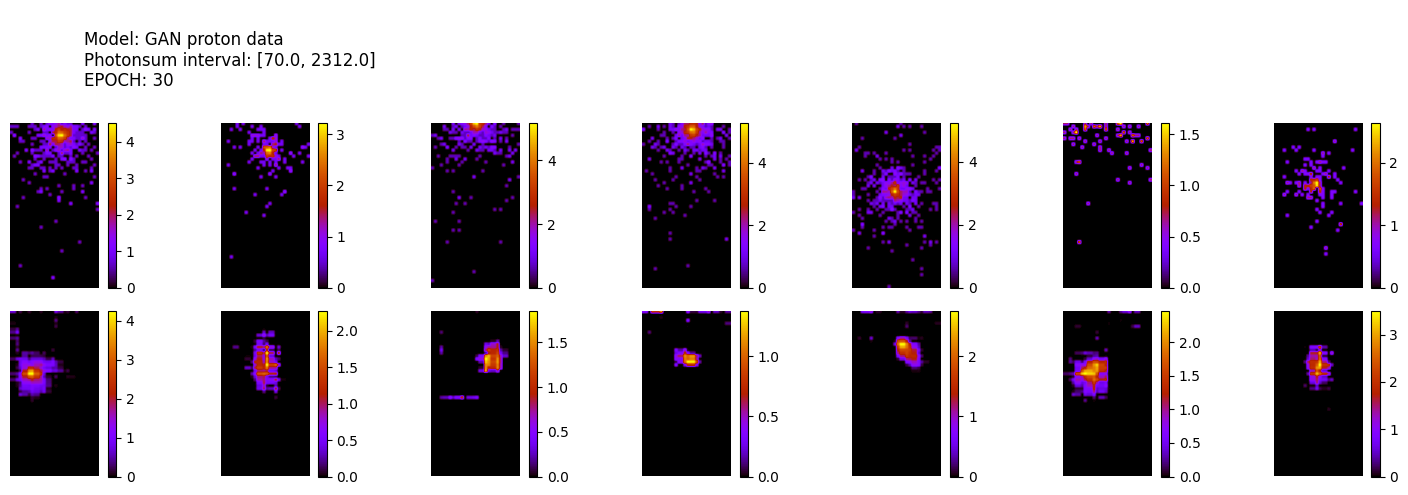

7900 [D real acc: 87.38%] [D fake acc: 84.66%] [G acc: 15.34%] 
256/256 [==============================] - 1s 3ms/step
ws mean 58.78 ch1 0.76 ch2 124.19 ch3 0.36 ch4 51.74 ch5 116.86 Time for epoch 31 is 31.55544090270996 sec
8000 [D real acc: 87.52%] [D fake acc: 84.79%] [G acc: 15.21%] 
8100 [D real acc: 87.66%] [D fake acc: 84.92%] [G acc: 15.08%] 
256/256 [==============================] - 1s 3ms/step
ws mean 371.96 ch1 1.73 ch2 370.03 ch3 1.30 ch4 556.20 ch5 930.56 Time for epoch 32 is 30.15088987350464 sec
8200 [D real acc: 87.80%] [D fake acc: 85.07%] [G acc: 14.93%] 
8300 [D real acc: 87.93%] [D fake acc: 85.21%] [G acc: 14.79%] 
8400 [D real acc: 88.07%] [D fake acc: 85.35%] [G acc: 14.65%] 


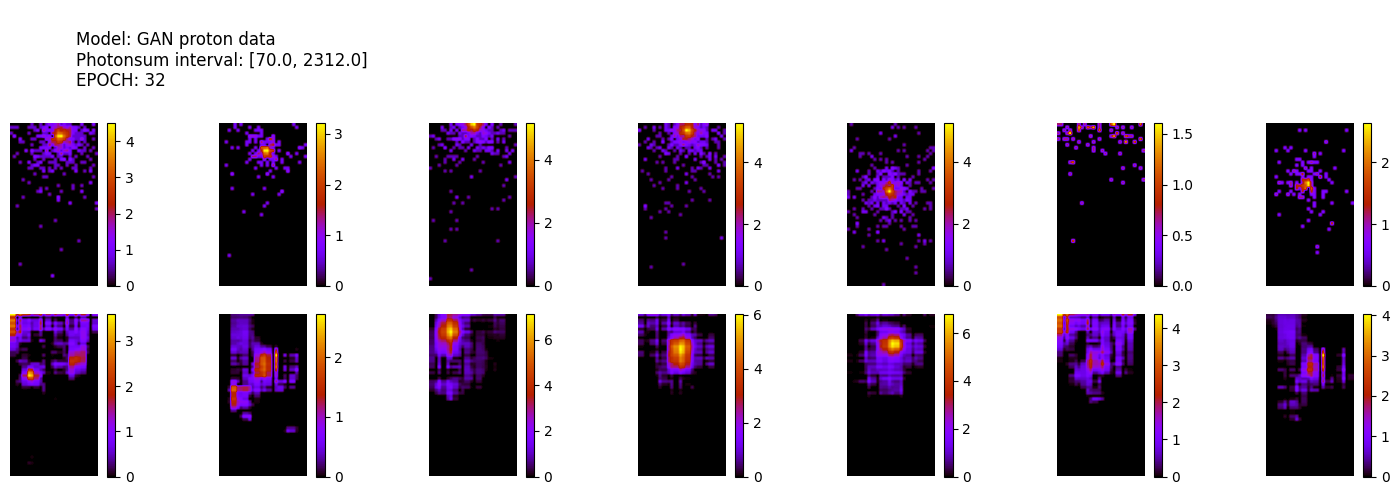

256/256 [==============================] - 1s 3ms/step
ws mean 334.80 ch1 0.45 ch2 102.45 ch3 2.95 ch4 736.74 ch5 831.40 Time for epoch 33 is 31.578256845474243 sec
8500 [D real acc: 88.20%] [D fake acc: 85.50%] [G acc: 14.50%] 
8600 [D real acc: 88.32%] [D fake acc: 85.64%] [G acc: 14.36%] 
8700 [D real acc: 88.44%] [D fake acc: 85.77%] [G acc: 14.23%] 
256/256 [==============================] - 1s 3ms/step
ws mean 73.14 ch1 0.27 ch2 74.21 ch3 0.51 ch4 136.05 ch5 154.67 Time for epoch 34 is 30.1055269241333 sec
8800 [D real acc: 88.56%] [D fake acc: 85.90%] [G acc: 14.10%] 
8900 [D real acc: 88.68%] [D fake acc: 86.03%] [G acc: 13.97%] 
256/256 [==============================] - 1s 3ms/step
ws mean 94.19 ch1 0.50 ch2 125.23 ch3 0.61 ch4 159.33 ch5 185.29 Time for epoch 35 is 29.920945644378662 sec
9000 [D real acc: 88.80%] [D fake acc: 86.16%] [G acc: 13.84%] 


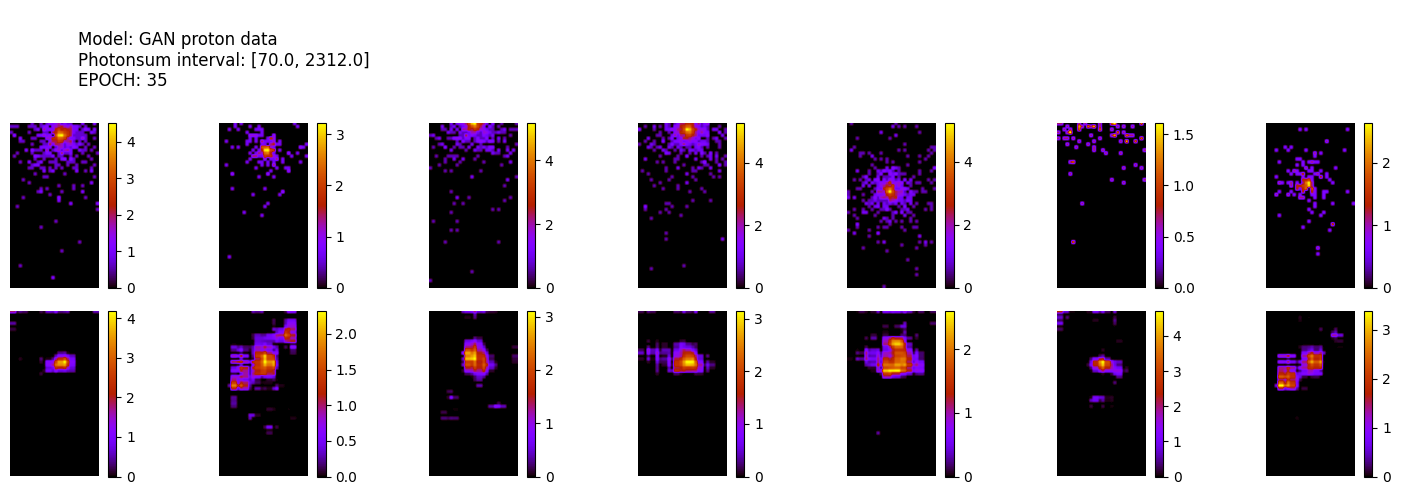

9100 [D real acc: 88.91%] [D fake acc: 86.30%] [G acc: 13.70%] 
9200 [D real acc: 89.03%] [D fake acc: 86.45%] [G acc: 13.55%] 
256/256 [==============================] - 1s 3ms/step
ws mean 161549.14 ch1 0.20 ch2 407221.85 ch3 0.79 ch4 284.15 ch5 400238.69 Time for epoch 36 is 31.705922603607178 sec
9300 [D real acc: 89.14%] [D fake acc: 86.59%] [G acc: 13.41%] 
9400 [D real acc: 89.25%] [D fake acc: 86.73%] [G acc: 13.27%] 
256/256 [==============================] - 1s 3ms/step
ws mean 128.78 ch1 0.21 ch2 112.50 ch3 0.79 ch4 208.67 ch5 321.74 Time for epoch 37 is 29.89686417579651 sec
9500 [D real acc: 89.36%] [D fake acc: 86.87%] [G acc: 13.13%] 
9600 [D real acc: 89.46%] [D fake acc: 87.00%] [G acc: 13.00%] 


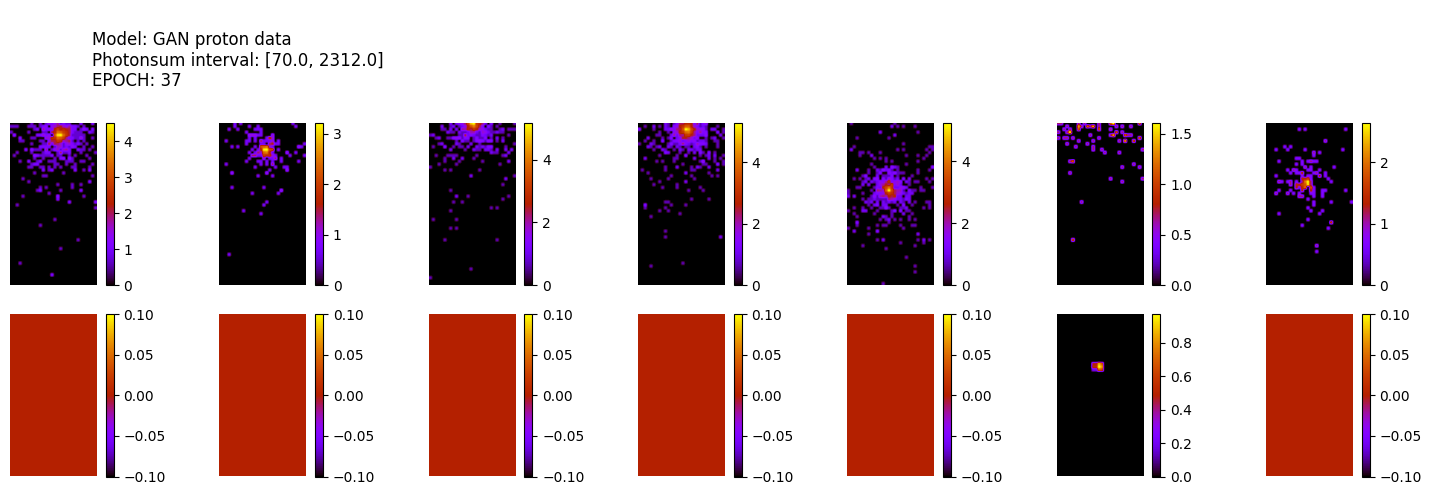

9700 [D real acc: 89.57%] [D fake acc: 87.13%] [G acc: 12.87%] 
256/256 [==============================] - 1s 3ms/step
ws mean 128.88 ch1 0.21 ch2 113.07 ch3 0.79 ch4 208.36 ch5 321.99 Time for epoch 38 is 31.778564453125 sec
9800 [D real acc: 89.67%] [D fake acc: 87.26%] [G acc: 12.74%] 
9900 [D real acc: 89.78%] [D fake acc: 87.39%] [G acc: 12.61%] 
256/256 [==============================] - 1s 3ms/step
ws mean 126.07 ch1 0.17 ch2 106.09 ch3 0.79 ch4 208.33 ch5 314.95 Time for epoch 39 is 29.923972368240356 sec
10000 [D real acc: 89.88%] [D fake acc: 87.51%] [G acc: 12.49%] 
10100 [D real acc: 89.98%] [D fake acc: 87.63%] [G acc: 12.37%] 
10200 [D real acc: 90.07%] [D fake acc: 87.74%] [G acc: 12.26%] 


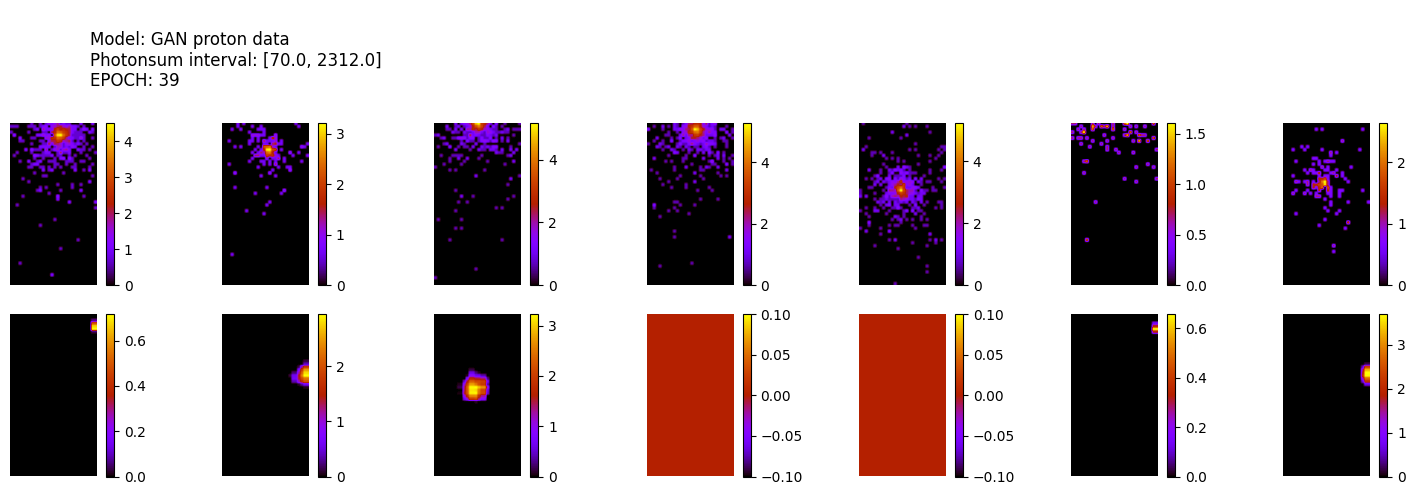

256/256 [==============================] - 1s 3ms/step
ws mean 96.43 ch1 0.21 ch2 46.71 ch3 0.79 ch4 207.08 ch5 227.36 Time for epoch 40 is 31.725595712661743 sec
10300 [D real acc: 90.17%] [D fake acc: 87.85%] [G acc: 12.15%] 
10400 [D real acc: 90.26%] [D fake acc: 87.95%] [G acc: 12.05%] 
256/256 [==============================] - 1s 3ms/step
ws mean 84.38 ch1 0.22 ch2 53.79 ch3 0.66 ch4 169.81 ch5 197.41 Time for epoch 41 is 29.878686666488647 sec
10500 [D real acc: 90.34%] [D fake acc: 88.05%] [G acc: 11.95%] 
10600 [D real acc: 90.43%] [D fake acc: 88.15%] [G acc: 11.85%] 
10700 [D real acc: 90.51%] [D fake acc: 88.24%] [G acc: 11.76%] 
256/256 [==============================] - 1s 3ms/step
ws mean 81.64 ch1 0.19 ch2 73.21 ch3 0.57 ch4 142.94 ch5 191.30 Time for epoch 42 is 30.23387312889099 sec
10800 [D real acc: 90.60%] [D fake acc: 88.32%] [G acc: 11.68%] 


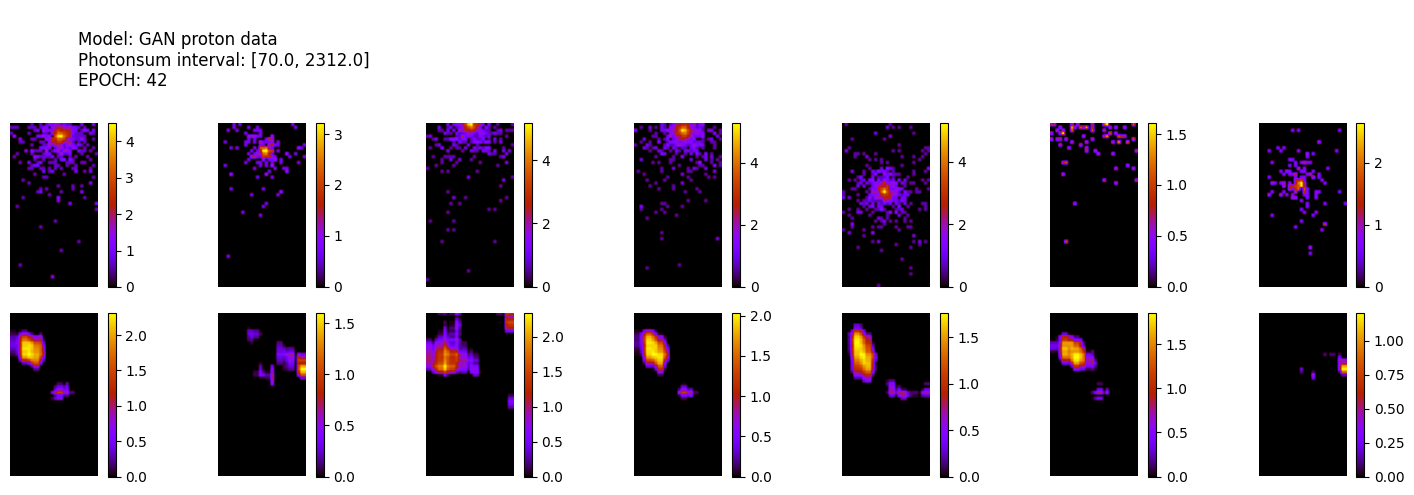

10900 [D real acc: 90.67%] [D fake acc: 88.42%] [G acc: 11.58%] 
11000 [D real acc: 90.75%] [D fake acc: 88.51%] [G acc: 11.49%] 
256/256 [==============================] - 1s 3ms/step
ws mean 91.48 ch1 0.17 ch2 63.41 ch3 0.67 ch4 172.77 ch5 220.39 Time for epoch 43 is 31.722859144210815 sec
11100 [D real acc: 90.83%] [D fake acc: 88.60%] [G acc: 11.40%] 
11200 [D real acc: 90.91%] [D fake acc: 88.69%] [G acc: 11.31%] 
256/256 [==============================] - 1s 3ms/step
ws mean 88.24 ch1 0.15 ch2 72.23 ch3 0.58 ch4 151.39 ch5 216.82 Time for epoch 44 is 29.90352773666382 sec
11300 [D real acc: 90.98%] [D fake acc: 88.77%] [G acc: 11.23%] 
11400 [D real acc: 91.06%] [D fake acc: 88.86%] [G acc: 11.14%] 


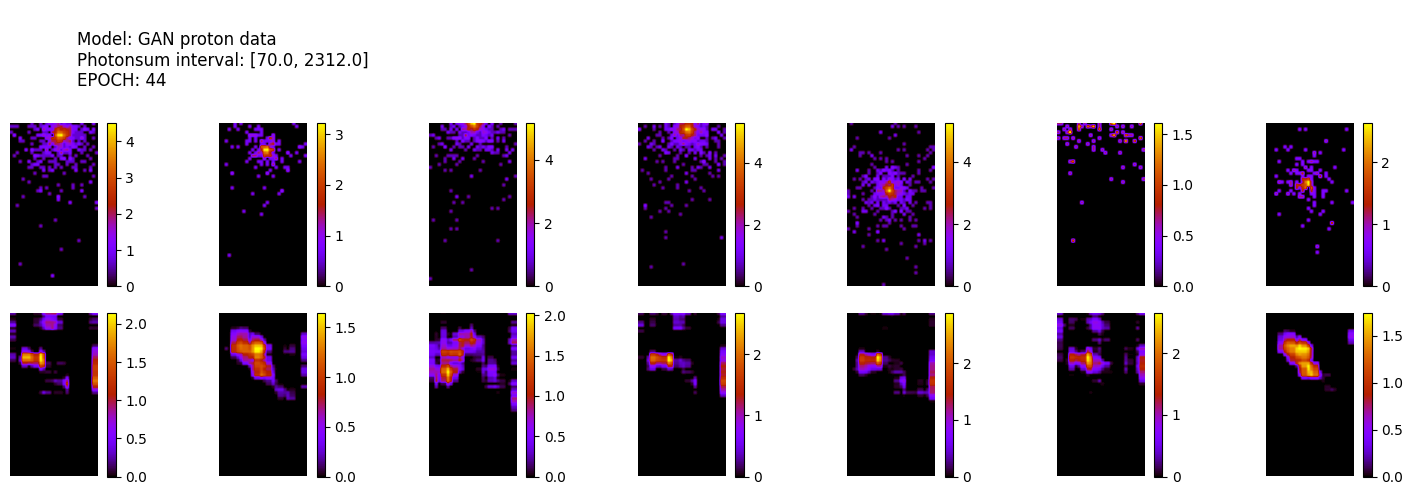

11500 [D real acc: 91.13%] [D fake acc: 88.94%] [G acc: 11.06%] 
256/256 [==============================] - 1s 3ms/step
ws mean 88.16 ch1 0.28 ch2 72.33 ch3 0.65 ch4 165.14 ch5 202.40 Time for epoch 45 is 31.849512338638306 sec
11600 [D real acc: 91.20%] [D fake acc: 89.03%] [G acc: 10.97%] 
11700 [D real acc: 91.27%] [D fake acc: 89.11%] [G acc: 10.89%] 
256/256 [==============================] - 1s 3ms/step
ws mean 90.18 ch1 0.20 ch2 75.94 ch3 0.61 ch4 159.11 ch5 215.06 Time for epoch 46 is 30.198519706726074 sec
11800 [D real acc: 91.34%] [D fake acc: 89.19%] [G acc: 10.81%] 
11900 [D real acc: 91.41%] [D fake acc: 89.27%] [G acc: 10.73%] 
12000 [D real acc: 91.48%] [D fake acc: 89.35%] [G acc: 10.65%] 


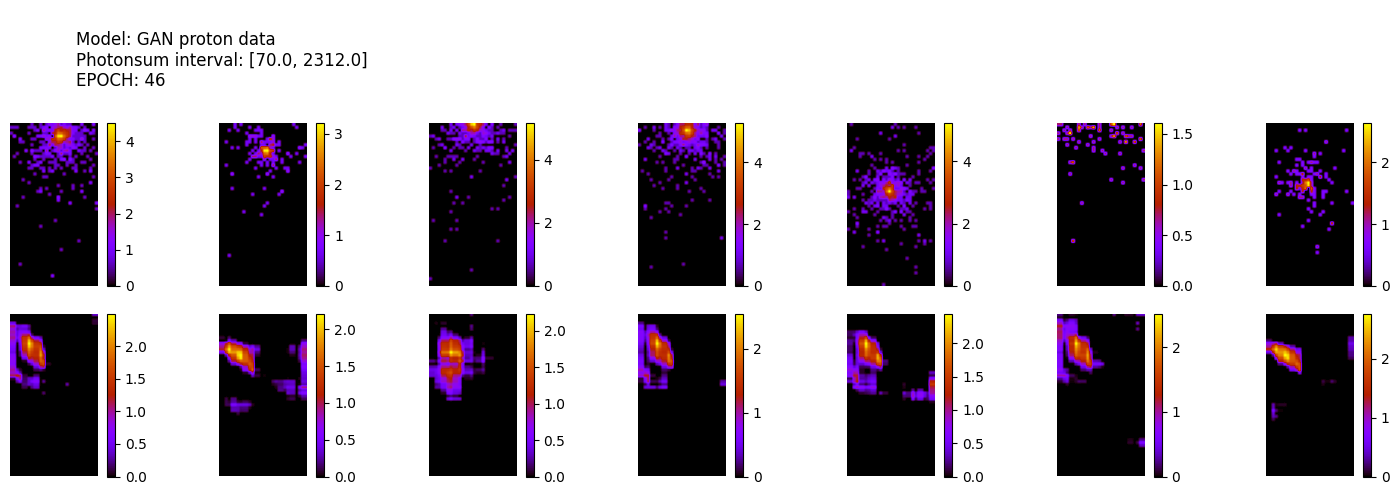

256/256 [==============================] - 1s 3ms/step
ws mean 85.08 ch1 0.16 ch2 71.54 ch3 0.59 ch4 149.16 ch5 203.95 Time for epoch 47 is 31.52428364753723 sec
12100 [D real acc: 91.55%] [D fake acc: 89.43%] [G acc: 10.57%] 
12200 [D real acc: 91.61%] [D fake acc: 89.51%] [G acc: 10.49%] 
256/256 [==============================] - 1s 3ms/step
ws mean 85.57 ch1 0.13 ch2 66.18 ch3 0.56 ch4 147.40 ch5 213.60 Time for epoch 48 is 30.158949851989746 sec
12300 [D real acc: 91.68%] [D fake acc: 89.58%] [G acc: 10.42%] 
12400 [D real acc: 91.74%] [D fake acc: 89.66%] [G acc: 10.34%] 
12500 [D real acc: 91.81%] [D fake acc: 89.73%] [G acc: 10.27%] 
256/256 [==============================] - 1s 3ms/step
ws mean 83.63 ch1 0.11 ch2 74.13 ch3 0.55 ch4 140.52 ch5 202.82 Time for epoch 49 is 29.96493625640869 sec
12600 [D real acc: 91.87%] [D fake acc: 89.81%] [G acc: 10.19%] 


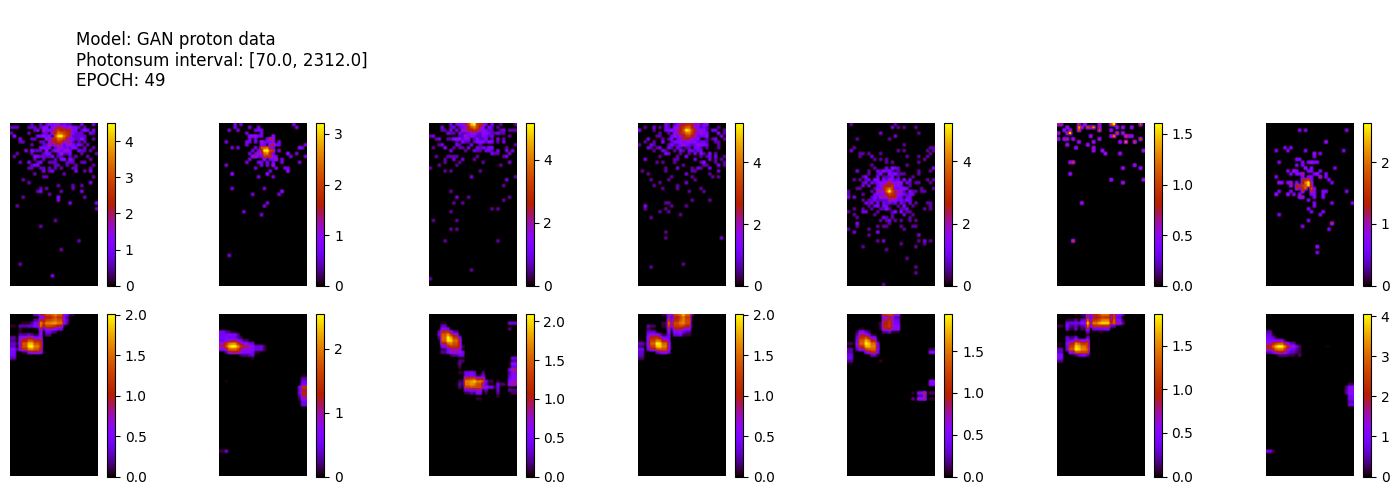

12700 [D real acc: 91.93%] [D fake acc: 89.88%] [G acc: 10.12%] 
12800 [D real acc: 91.99%] [D fake acc: 89.95%] [G acc: 10.05%] 
256/256 [==============================] - 1s 3ms/step
ws mean 86.75 ch1 0.10 ch2 72.49 ch3 0.60 ch4 156.48 ch5 204.09 Time for epoch 50 is 31.77822256088257 sec
12900 [D real acc: 92.05%] [D fake acc: 90.02%] [G acc: 9.98%] 
13000 [D real acc: 92.11%] [D fake acc: 90.10%] [G acc: 9.90%] 
256/256 [==============================] - 1s 3ms/step
ws mean 116.42 ch1 0.16 ch2 92.03 ch3 0.77 ch4 199.35 ch5 289.80 Time for epoch 51 is 29.927955389022827 sec
13100 [D real acc: 92.16%] [D fake acc: 90.17%] [G acc: 9.83%] 
13200 [D real acc: 92.22%] [D fake acc: 90.25%] [G acc: 9.75%] 


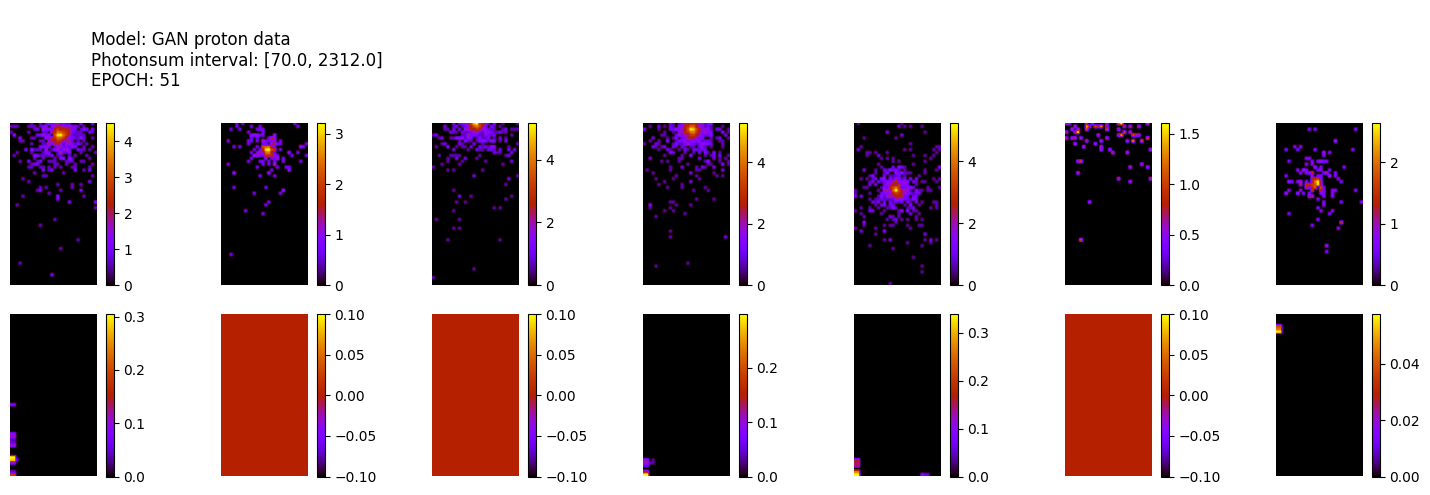

13300 [D real acc: 92.28%] [D fake acc: 90.32%] [G acc: 9.68%] 
256/256 [==============================] - 1s 3ms/step
ws mean 107328503245572069654528.00 ch1 0.41 ch2 260596974977395665666048.00 ch3 0.73 ch4 26073074203945070592.00 ch5 276019468176260797038592.00 Time for epoch 52 is 31.774782419204712 sec
13400 [D real acc: 92.34%] [D fake acc: 90.39%] [G acc: 9.61%] 
13500 [D real acc: 92.39%] [D fake acc: 90.46%] [G acc: 9.54%] 
256/256 [==============================] - 1s 3ms/step
ws mean 127.09 ch1 0.21 ch2 112.90 ch3 0.79 ch4 204.08 ch5 317.45 Time for epoch 53 is 30.14536190032959 sec
13600 [D real acc: 92.45%] [D fake acc: 90.53%] [G acc: 9.47%] 
13700 [D real acc: 92.50%] [D fake acc: 90.60%] [G acc: 9.40%] 
13800 [D real acc: 92.56%] [D fake acc: 90.67%] [G acc: 9.33%] 


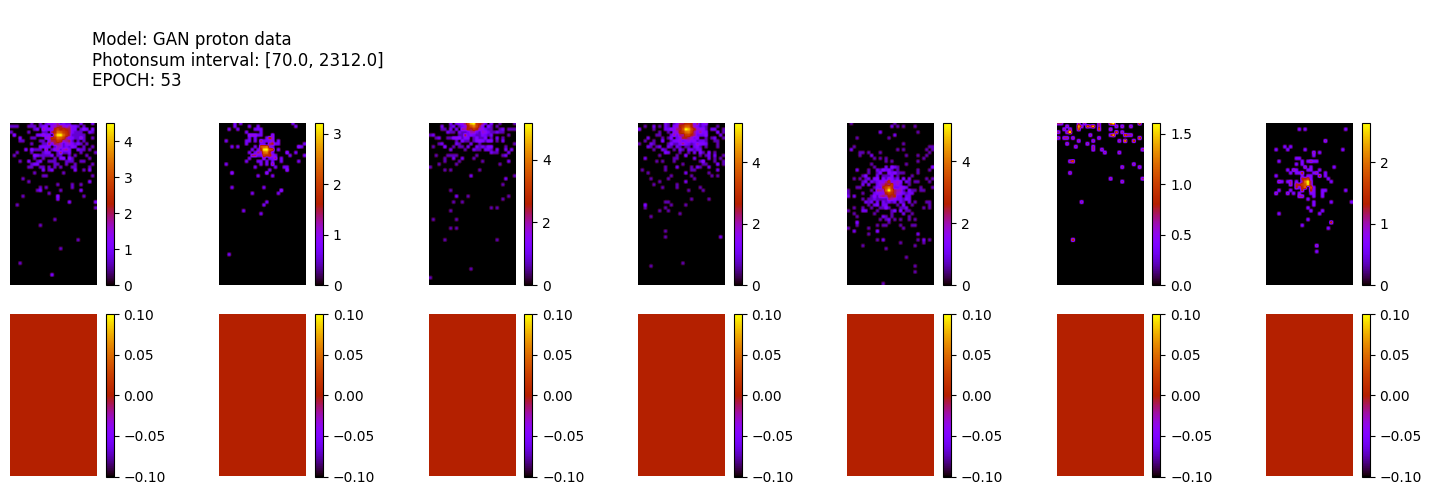

256/256 [==============================] - 1s 3ms/step
ws mean 128.60 ch1 0.20 ch2 112.18 ch3 0.79 ch4 208.56 ch5 321.27 Time for epoch 54 is 31.774343252182007 sec
13900 [D real acc: 92.61%] [D fake acc: 90.73%] [G acc: 9.27%] 
14000 [D real acc: 92.66%] [D fake acc: 90.80%] [G acc: 9.20%] 
256/256 [==============================] - 1s 3ms/step
ws mean 127.91 ch1 0.25 ch2 134.77 ch3 0.78 ch4 187.83 ch5 315.90 Time for epoch 55 is 29.852248668670654 sec
14100 [D real acc: 92.71%] [D fake acc: 90.86%] [G acc: 9.14%] 
14200 [D real acc: 92.76%] [D fake acc: 90.93%] [G acc: 9.07%] 
14300 [D real acc: 92.81%] [D fake acc: 90.98%] [G acc: 9.02%] 
256/256 [==============================] - 1s 3ms/step
ws mean 318.65 ch1 1.91 ch2 436.37 ch3 0.52 ch4 350.60 ch5 803.85 Time for epoch 56 is 29.81685757637024 sec


KeyboardInterrupt: 

In [26]:
print("Images are saved in: ", filepath_img)
print("Models are saved in: ", filepath_mod)
history=train(dataset_with_cond, EPOCHS)